Importando as bibliotecas utilizadas ... 

In [62]:
import numpy as np
import pandas as pd
import pickle
import gensim
import spacy

Inicializando o DataFrame da matriz dos conhecimentos, 
utilizando a função 'fillna' para consertar as células mescladas,
lendo a partir da linha 4
e lendo até a coluna 9 (excluso)

In [63]:
crea_df = pd.read_excel("Matriz_do_Conhecimento.xls", skiprows=4).iloc[:, :9].fillna(method="ffill")

Corrigindo valores que foram incorretamente preenchido pelo método fillna("ffill"):

In [64]:
crea_df = crea_df.replace({"TÓPICOS": np.NaN, "Nº DE ORDEM DOS TÓPICOS": np.NaN})

Salvando o Dataframe com o pickle

In [65]:
with open('crea_df_pickle.txt', 'wb') as f:
    pickle.dump(crea_df, f)

Abrindo o dataFrame em formato Binário e Imprimindo o DataFrame para fins de visualização:

In [66]:
with open('crea_df_pickle.txt', 'rb') as f:
    crea_df = pickle.load(f)

Acessando a seção de Mecatrônica do documento disponibilizado pelo Crea.

In [67]:
# * "Construção de Edificações" subsection
# subsection1_df = crea_df[ crea_df['SUB-SETOR' ] == 'Construção de Edificações']

# * "mechatronics" section
mechatronics_df = crea_df[ crea_df['SETOR'] == 'Controle e Automação']

# mechatronics_df

Importando as matérias que foram manualmente obtidas e salvas em um arquivo json. E ordenando pelos códigos das matérias

In [68]:
subjects_df = pd.read_json("MechatronicsEngeneeringSubjects.json")

subjects_df = subjects_df.sort_values(by=["codigo"])

subjects_df = subjects_df.reset_index(drop=True)

# subjects_df

Criando uma função de pre-processamento de texto. Retira ruidos(cleaning) -> tokeniza-lemmatiza -> depois retira stopwords;

Recebe um texto no formato de string e retorna uma lista de strings com as palavras do documento.

In [69]:
from nltk.corpus import stopwords

nlp = spacy.load('pt_core_news_lg')

# TODO: find out if it is definately impossible to disable PoS tags in nlp model; alternative: convert all verbs to noun using wordnet and .pos from spacy?
# TODO: implementar o tagger utilizando o seguinte banco de dados: https://www.nltk.org/howto/portuguese_en.html#accessing-the-macmorpho-tagged-corpus
# tagger = nlp.get_pipe("tagger")
# doc = nlp("eletromagnetismo serie")
# print(tagger.model.predict([doc])[0][1])
# print(tagger.labels)

# * adding custom texts that dont represent real words
noises_list = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x", "xi"]

stopWords_list = stopwords.words("portuguese")

# * adding custom words to StopWords list
stopWords_list += [
    'referente',
    'seguinte',
    'etc',
    'ª',
    'tal',
    'um', 
    'dois',
    'tres',
    'vs',
    'aula',
    'tal',
]

# * preprocessing stopwords to correct format
stopWords_list = gensim.utils.simple_preprocess(" ".join(stopWords_list), deacc=True, min_len=1, max_len=40)

# print(stopWords_list)

# * manual intervention, changing final lemmas
intervention_dict = {
    "campar": "campo",
    "seriar":"serie",
    "eletromagnetico":"eletromagnetismo",
}

def preprocess(text):
    # * importing stopwords from nltk and spacy pipeline
    global nlp
    global stopWords_list
    global noises_list
    global intervention_dict

    # * preprocessing text with gensim.simple_preprocess, eliminating noises: lowercase, tokenized, no symbols, no numbers, no accents marks(normatize)
    text_list = gensim.utils.simple_preprocess(text, deacc=True, min_len=1, max_len=40)

    # * recombining tokens to a string type object and removing remaining noises
    text_str = " ".join([word for word in text_list if word not in noises_list])

    # * preprocessing with spacy, retokenizing -> tagging parts of speech (PoS) -> parsing (assigning dependencies between words) -> lemmatizing
    text_doc = nlp(text_str)

    # * re-tokenization, removing stopwords and lemmatizing
    lemmatized_text_list = [token.lemma_ for token in text_doc if token.text not in stopWords_list]

    # * manual intervention conversion of lemmas and removing 1 letter stopwords
    output = []
    for token in lemmatized_text_list:
        if len(token) <= 1:
            continue
        if token in intervention_dict:
            output.append(intervention_dict[token])
        else:
            output.append(token)
            
    return output

Pre-processando as matérias com Stopwords do NLTK e função do Gensim. E adicionando uma nova columa ao Dataframe que consiste em todo o texto da matéria

In [70]:
documents_list = []

for i, row in subjects_df.iterrows():

    # * reading values of each subject (row)
    subject_id = row["codigo"]
    name = row["nome"]
    syllabus = row["ementa"]
    content = row["conteudo"]

    # * combining them to create the subject document
    text = name + ' ' + syllabus + ' ' + content
    
    # * preprocessing
    preProcessedText = preprocess(text)
    documents_list.append(preProcessedText)

# print(documents_list)

documents_series = pd.Series(documents_list, name="documento")

documents_df = pd.concat([subjects_df, documents_series], axis=1)

# documents_df

Salvando o Dataframe das matérias,  reabrindo-o e imprimindo o DataFrame para fins de visualização:

In [71]:
with open('documents_df.txt', 'wb') as f:
    pickle.dump(documents_df, f)

In [72]:
with open('documents_df.txt', 'rb') as f:
    documents_df = pickle.load(f)

# documents_df

Salvando a coluna de documentos para tornar legível e facilitar a busca, assim podendo conferir se os lemmas estão satisfatórios e se condizem

In [73]:
import json
with open("debbuging_docs.json", "w+") as f:
    json.dump(documents_df['documento'].to_dict(), f, indent=4, ensure_ascii=True)

construindo o Corpus, vetorizando os documentos com o bag-of-words do gensim

In [74]:
from gensim import corpora

lemmatizedData = documents_df["documento"].tolist()

# * gensim dictionary object, which will track each word to its respective id
id2wordDict = corpora.Dictionary(lemmatizedData)

# * gensim doc2bow method to map each word to a integer id and its respective frequency
corpus = [id2wordDict.doc2bow(text) for text in lemmatizedData]

# * list of list of tuples (id of a word, frequency)
# corpus

Utilizando tf-idf do gensim para descobrir as palavras mais importantes e dar mais pesos a elas;

tupla(int, int) -> tupla(int, float)

td-idf(term_i, document_j) = freq(i,j) * log2 ( inverse_document_frequency(i) )

freq(i, j) = total occurances of i in j / total words in j

inverse_document_frequency(i) = total documents / documents that have at least one occurance of i 

O parâmetro id2word recebe o dicionário que mapeia as palavras com os respectivos IDs.

In [75]:
tfidf_model = gensim.models.TfidfModel(corpus, id2word=id2wordDict)

LSI, pega a matriz do corpus e a decompõe utilizando o SVD. Das três matrizes criadas, utiliza-se apenas o right singular vectors que representa a relação entre os tópicos latentes com as palavras.

O parâmetro id2word recebe o dicionário que mapeia as palavras com os respectivos IDs. E o parâmetro power_iters define o número de iterações para treinamento do modelo, e, portanto, quanto maior o valor, mais acurado e mais devagar vai ser o treino modelo

In [76]:
lsi_model = gensim.models.LsiModel(tfidf_model[corpus], id2word=id2wordDict, num_topics=100, power_iters=100)

# lsi_model.print_topics(num_topics=56)

left singular vector -> term-to-topic matrix (não será utilizado)

In [77]:
# * U Matrix
print(np.shape(lsi_model.projection.u))

# lsi_model.projection.u

(2030, 57)


singular values -> "impacto" (abrangência?) de cada tópico -> "feature importance"

Pode-se escolher um valor de corte para reduzir o valor do parametro num_topics, aumentando, assim, o desempenho de tempo. O número de tópicos latentes não tem como ser maior que o numero de documentos

In [78]:
print("número de documentos/ementas/matérias:", len(subjects_df))
print("topicos latentes encontrados com um \'impacto alto\':", len(lsi_model.projection.s))

# * S matrix (sigma)
# print(np.shape(lsi_model.projection.s))
# lsi_model.projection.s

número de documentos/ementas/matérias: 58
topicos latentes encontrados com um 'impacto alto': 57


right singular vectors -> document-to-topic matrix (Não é diretamente calculado e armazenado pois pode ser muito grande devido a quantidade de documentos -> num_topic x documents)

Será o documento armazenado e utilizado para fazer as queries de similaridade

In [79]:
V_matrix = gensim.matutils.corpus2dense(lsi_model[tfidf_model[corpus]], len(lsi_model.projection.s)).T / lsi_model.projection.s
print(np.shape(V_matrix))
# * V or V^T matrix
# * representado por lsi_model[x]
V_matrix

(58, 57)


array([[-0.01951072, -0.01026735,  0.00636971, ..., -0.00112256,
         0.00569757, -0.00026312],
       [-0.08168424, -0.01906994, -0.00326056, ...,  0.01171658,
         0.01533635, -0.00456398],
       [-0.04390924, -0.02216211,  0.00204209, ...,  0.01106124,
         0.00088687, -0.01433655],
       ...,
       [-0.09469698,  0.02248303,  0.01152621, ..., -0.04748874,
         0.05445651, -0.0059094 ],
       [-0.07132712,  0.00812746,  0.06383357, ..., -0.01837771,
        -0.00670109, -0.00366831],
       [-0.02219705,  0.00230684,  0.01235689, ..., -0.00402028,
        -0.00055404,  0.00072604]])

Salvando, então, o corpus já processado pelo tf_idf e também a matrix V de LSI em um arquivo texto do tipo Matrix Market format, que permite que a matriz seja guardado em um arquivo texto, mas também pode ser utilizado para cálculos. (o método Serialize guardas os indexes)

In [80]:
gensim.corpora.MmCorpus.serialize('tfidf_model_mm', tfidf_model[corpus])
gensim.corpora.MmCorpus.serialize('lsi_model_mm', lsi_model[tfidf_model[corpus]])

Abrindo as matrizes salvas nos arquivos textos

In [81]:
tfidf_corpus = gensim.corpora.MmCorpus('tfidf_model_mm')
lsi_corpus = gensim.corpora.MmCorpus('lsi_model_mm')

# * features of td-idf matrix are the different words
print(tfidf_corpus)

# * features of LSI model are the latent topics discovered
print(lsi_corpus)

MmCorpus(58 documents, 2030 features, 4329 non-zero entries)
MmCorpus(58 documents, 57 features, 3306 non-zero entries)


Buscas de Similaridade Semântica utilizando o método Matrix similarity do gensim, o qual computa o "cosine similarity".

Se forem buscados termos que não foram adicionados ao dicionário id2wordDict, não há como mapear esse documento

O parâmetro num_best define quantos dos documentos mais proximos será buscado

In [82]:
from gensim.similarities.docsim import MatrixSimilarity

cosineSimilarityTop8 = MatrixSimilarity(lsi_corpus, num_features = lsi_corpus.num_terms, num_best=8)
cosineSimilarityAll = MatrixSimilarity(lsi_corpus, num_features = lsi_corpus.num_terms)

def search_similarity_query_top8(search_document):

    # * preprocessing and processing until becomes a matrix of type term_to_topic (V)
    doc = preprocess(search_document)
    query_bow = id2wordDict.doc2bow(doc)
    query_tfidf = tfidf_model[query_bow]
    query_lsi = lsi_model[query_tfidf]

    # * cossine similarity between the vector of the new document vs all other vectors of documents
    # * returns a list of top 8 tuples (id of compared document, similarity)
    ranking = cosineSimilarityTop8[query_lsi]

    ranking.sort(key=lambda unit: unit[1], reverse= True)
    result = []

    for subject in ranking:

        result.append (
            {
                'Relevancia': round((subject[1] * 100),6),
                'Código da Matéria': subjects_df['codigo'][subject[0]],
                'Nome da matéria': subjects_df['nome'][subject[0]]
            }

        )
    
    output = pd.DataFrame(result, columns=['Relevancia','Código da Matéria','Nome da matéria'])
    
    return output

def search_similarity_query_all(search_document):
    
    # * preprocessing and processing until becomes a matrix of type term_to_topic (V)
    doc = preprocess(search_document)
    query_bow = id2wordDict.doc2bow(doc)
    query_tfidf = tfidf_model[query_bow]
    query_lsi = lsi_model[query_tfidf]

    # * cossine similarity between the vector of the new document vs all other vectors of documents
    # * returns a list of tuples (id of compared document, similarity)
    ranking = cosineSimilarityAll[query_lsi]
    
    return ranking



Utilizando documentos no formato de str, pode-se realizar buscas de similaridade semântica entre as matérias

In [83]:
print(preprocess("Administração Gestão da Produção, Financeira e de Pessoas"))
print(search_similarity_query_top8("Administração Gestão da Produção, Financeira e de Pessoas"))
print(search_similarity_query_all("Administração Gestão da Produção, Financeira e de Pessoas"))

['administracao', 'gestao', 'producao', 'financeiro', 'pessoa']
   Relevancia Código da Matéria                      Nome da matéria
0   80.546463           ADM0023           INTRODUÇÃO À ADMINISTRAÇÃO
1   60.033923           EPR0068               ORGANIZAÇÃO INDUSTRIAL
2   10.899784           ECO0019                INTRODUÇÃO À ECONOMIA
3    8.834535           ENM0134    SISTEMAS INTEGRADOS DE MANUFATURA
4    2.311527           ENE0047  CONVERSÃO ELETROMECÂNICA DE ENERGIA
5    2.003992           ENE0240              CONTROLE PARA AUTOMAÇÃO
6    0.000003           SOL0042              INTRODUÇÃO À SOCIOLOGIA
7    0.000002           ENM0127           TECNOLOGIA DE FABRICACAO 1
[ 8.0546463e-01  3.7252903e-09 -1.1175871e-08  2.2351742e-08
 -1.4901161e-08 -3.7252903e-09  1.8626451e-09  0.0000000e+00
  1.8626451e-09 -2.2351742e-08  1.0899784e-01 -3.7252903e-09
 -3.7252903e-09  2.3115270e-02 -1.4901161e-08  7.4505806e-09
  0.0000000e+00 -4.6566129e-09  7.4505806e-09 -3.7252903e-09
 -7.450580

Acessando os conteúdos do curso de Mecatrônica, retirando os duplicados do Dataframe de Mecatrônica que pertencem a subseções diferentes:

In [84]:
mechatronics_knowledge_df = pd.DataFrame(columns=['area do conhecimento', 'conteudo'])

visited_knowledge = {}

for i, row in mechatronics_df.iterrows():
    text = row[7] + ' ' + row[8]
    if text in visited_knowledge:
        continue
    visited_knowledge[text] = (row[7], row[8])
    mechatronics_knowledge_df.loc[len(mechatronics_knowledge_df.index)] = [row[7], row[8]]

mechatronics_knowledge_df = mechatronics_knowledge_df.sort_values(by=["area do conhecimento", "conteudo"])

mechatronics_knowledge_df = mechatronics_knowledge_df.reset_index(drop=True)

mechatronics_knowledge_df

,area do conhecimento,conteudo
0,Administração,Empreendedorismo
1,Administração,"Gestão da Produção, Financeira e de Pessoas"
2,Administração,Gestão de Projetos
3,Administração,Marketing
4,Administração,Modelos de Organização
...,...,...
217,Telecomunicações,Multiplexação Analógica e Digital
218,Telecomunicações,Métodos de Modulação Analógicos e Digitais
219,Telecomunicações,Redes Lógicas
220,Telecomunicações,Sistemas de Comunicações Móveis


Multi-queries in the Mecatronics section. Saving top 8 query into a text file and creating a Dataframe for all predicted labels:

In [85]:
query_full_text = ""
for i, row in mechatronics_knowledge_df.iterrows():
    text = row[0] + ' ' + row[1]
    query_full_text += "Index: " + str(i) + '\n'
    query_full_text += "área do conhecimento: " + row[0] + '\n'
    query_full_text += "Conteúdo buscado: " + row[1] + '\n'
    query_full_text += "Texto buscado depois de preprocessado: " + str(preprocess(text)) + '\n'
    query_full_text += search_similarity_query_top8(text).to_string() + "\n\n"

with open("mechatronics_requirements_query.txt", 'w') as f:
    f.write(query_full_text)

Creating a function to perform multiple queries and generate predictions dataframe:

In [92]:
def multi_queries(threshold=0.545):
    predicted_labels = pd.DataFrame(columns= subjects_df['codigo'])

    query_full_text = ""
    for i, row in mechatronics_knowledge_df.iterrows():
        text = row[0] + ' ' + row[1]
        binary_values = np.array([1 if val >= threshold else 0 for val in search_similarity_query_all(text)])
        predicted_labels.loc[len(predicted_labels.index)] = binary_values

    with open("mechatronics_requirements_query.txt", 'w') as f:
        f.write(query_full_text)
    
    return predicted_labels

Creating a gold label dataframe

In [87]:
golden_df = pd.read_excel("conteudos_e_ementas.xlsx").iloc[:, 4:7].fillna(method="ffill")

gold_labels = pd.DataFrame(columns= subjects_df['codigo'])

for i, row in golden_df.iterrows():
    related = row[2].split(',')
    binary_values = [1 if val in related else 0 for val in subjects_df['codigo']]
    gold_labels.loc[len(gold_labels.index)] = binary_values

gold_labels

codigo,ADM0023,CIC0004,CIC0090,CIC0099,CIC0103,CIC0104,CIC0126,CIC0229,CIC0231,ECL0014,...,IFD0179,IFD0181,IQD0125,IQD0126,MAT0025,MAT0026,MAT0027,MAT0028,MAT0031,SOL0042
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
218,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Generating evaluation metrics for each knowledge from Mecatronics section

In [88]:
import sklearn

all_true = []
all_pred = []

predicted_labels = multi_queries()

for i, row in mechatronics_knowledge_df.iterrows():
    print(i, ':', row["area do conhecimento"], row["conteudo"])

    knowledge_true = gold_labels.iloc[i].to_list()
    knowledge_pred = predicted_labels.iloc[i].to_list()

    confu_matrix = sklearn.metrics.confusion_matrix(knowledge_true, knowledge_pred)
    print(confu_matrix)
    report = sklearn.metrics.classification_report(knowledge_true, knowledge_pred, digits=4, output_dict=False, zero_division=0)
    print(report)

    all_true += knowledge_true
    all_pred += knowledge_pred

#    True Negative (TN) pred=0, gold=0 | False Positive (FP) pred=1, gold=0
#    False Negative (FN) pred=0, gold=1| true positive (TP) pred=1, gold=1

(222, 58)
0 : Administração Empreendedorismo
[[57  1]
 [ 0  0]]
              precision    recall  f1-score   support

           0     1.0000    0.9828    0.9913        58
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9828        58
   macro avg     0.5000    0.4914    0.4957        58
weighted avg     1.0000    0.9828    0.9913        58

1 : Administração Gestão da Produção, Financeira e de Pessoas
[[57  0]
 [ 0  1]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        57
           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000        58
   macro avg     1.0000    1.0000    1.0000        58
weighted avg     1.0000    1.0000    1.0000        58

2 : Administração Gestão de Projetos
[[57  1]
 [ 0  0]]
              precision    recall  f1-score   support

           0     1.0000    0.9828    0.9913        58
           1     0.0000    0.0000   

Generating a overall evaluation metrics:

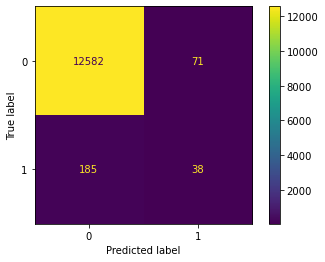

              precision    recall  f1-score   support

           0     0.9855    0.9944    0.9899     12653
           1     0.3486    0.1704    0.2289       223

    accuracy                         0.9801     12876
   macro avg     0.6671    0.5824    0.6094     12876
weighted avg     0.9745    0.9801    0.9767     12876



In [89]:
import matplotlib.pyplot as plt

all_confu_matrix = sklearn.metrics.confusion_matrix(all_true, all_pred)
display = sklearn.metrics.ConfusionMatrixDisplay(all_confu_matrix)
display.plot()
plt.show()

all_report = sklearn.metrics.classification_report(all_true, all_pred, digits=4, output_dict=False, zero_division=0)
print(all_report)

Creating a function to vary threshold: 

In [97]:
def process_data(threshold):
    all_true = []
    all_pred = []

    predicted_labels = multi_queries(threshold=threshold)

    for i, row in mechatronics_knowledge_df.iterrows():
        knowledge_true = gold_labels.iloc[i].to_list()
        knowledge_pred = predicted_labels.iloc[i].to_list()

        all_true += knowledge_true
        all_pred += knowledge_pred

    all_confu_matrix = sklearn.metrics.confusion_matrix(all_true, all_pred)
    print(all_confu_matrix)

    all_report = sklearn.metrics.classification_report(all_true, all_pred, digits=4, output_dict=False, zero_division=0)
    print(all_report)

def process_data_return_macro_avg(threshold):
    all_true = []
    all_pred = []

    predicted_labels = multi_queries(threshold=threshold)

    for i, row in mechatronics_knowledge_df.iterrows():
        knowledge_true = gold_labels.iloc[i].to_list()
        knowledge_pred = predicted_labels.iloc[i].to_list()

        all_true += knowledge_true
        all_pred += knowledge_pred

    return sklearn.metrics.f1_score(all_true, all_pred, average='macro')


# for i in range(20):
#     print('threshold:', i/20)
#     print(process_data_return_macro_avg(i/20))

for i in range(20):
    l = 0.5
    print('threshold:', l + i/200)
    print(process_data_return_macro_avg(l + i/200))

threshold: 0.5
0.6218283326021806
threshold: 0.505
0.6223395445134575
threshold: 0.51
0.6241559520200264
threshold: 0.515
0.6252133288941519
threshold: 0.52
0.6251865753104836
threshold: 0.525
0.6238073375349555
threshold: 0.53
0.6251563631303092
threshold: 0.535
0.625977194853168
threshold: 0.54
0.6256751095460773
threshold: 0.545
0.6279254463848767
threshold: 0.55
0.6273456664001251
threshold: 0.555
0.626179006745296
threshold: 0.56
0.6238025841192638
threshold: 0.565
0.6225922967468788
threshold: 0.5700000000000001
0.6243121474993406
threshold: 0.575
0.6227927793026151
threshold: 0.58
0.6218346965052675
threshold: 0.585
0.6227038685297839
threshold: 0.59
0.6244730208109848
threshold: 0.595
0.6240991045274675


Writing all topics and syllabus into a xlsx file (Already Done, no need to run anymore)

In [39]:
# import xlsxwriter

# workbook = xlsxwriter.Workbook('conteudos_e_ementas.xlsx')

# worksheet1 = workbook.add_worksheet()

# worksheet1.write(1, 1, "Código da Matéria")
# worksheet1.write(1, 2, "Nome da Matéria")
# row = 2
    
# for i, line in subjects_df.iterrows():
#     worksheet1.write(row, 1, line["codigo"])
#     worksheet1.write(row, 2, line["nome"])
#     row += 1

# worksheet1.write(1, 4, "Conteúdos")
# worksheet1.write(1, 5, "Área do Conhecimento")
# worksheet1.write(1, 6, "Ementa(s) Associadas")
# row = 2
# for item in visited_topics.values():
#     worksheet1.write(row, 4, item[0])
#     worksheet1.write(row, 5, item[1])
#     row += 1

# workbook.close()